In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd ..
import os 

import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision

from src.point_prompt_demo import PointPromptDemo
from src.model import MedSAM

/repo


In [3]:
def preprocess_image(image, device="cpu"):
    # Resizing
    if len(image.shape) == 2:
        image = np.repeat(image[:,:,None], 3, -1)
    img_resize = cv2.resize(
        image,
        (1024, 1024),
        interpolation=cv2.INTER_CUBIC
    )
    
    # normalize to [0, 1], (H, W, 3)
    img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) 
    # convert the shape to (3, H, W)
    assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
    img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(device)

    return img_tensor

In [4]:
def preprocess_gt(gt):
    gt2D = np.uint8(gt > 0)
    return torch.tensor(gt2D).long().unsqueeze(dim=0)

In [5]:
medsam_checkpoint = "weights/medsam/medsam_vit_b.pth"
checkpoint = "25-07-2024-09:22:56-epoch=106-loss_val=0.05.ckpt"
num_points = 50
device = "cpu"

medsam_model = MedSAM(
        medsam_checkpoint=medsam_checkpoint,
        freeze_image_encoder=True,
        num_points=num_points
).to(device)

checkpoint = torch.load(os.path.join("logs", checkpoint))
medsam_model.load_state_dict(checkpoint['state_dict'], strict=False)

Image encoder is frozen


<All keys matched successfully>

In [6]:
point_prompt_demo = PointPromptDemo(medsam_model)

In [7]:
image_name = "CT_Abd_word_0014-021.npy"
demo_file_img = os.path.join("data/WORD/test_CT_Abd/imgs", image_name)
demo_file_gt = os.path.join("data/WORD/test_CT_Abd/gts/", image_name)

img = np.load(demo_file_img)
gt = np.load(demo_file_gt)

In [8]:
gts = []
label_ids = np.unique(gt)[1:]  # [1,4,5...]
for label_id in label_ids:
    gt2D = np.uint8(gt == label_id) 
    gt2D = (gt2D * 255).astype(np.uint8)
    thresh = cv2.threshold(
        gt2D, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )[1]
    cnts = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for i in range(len(cnts)):
                
        mask = np.zeros_like(gt2D)
        cv2.drawContours(
            mask, cnts, i, (255, 255, 255), thickness=cv2.FILLED
        )
        gt_seg = np.uint8(mask == 255)
        gts.append((gt_seg, label_id))

In [9]:
len(gts)

4

In [10]:
gt = gts[3][0]

In [11]:
gts[3][1]

16

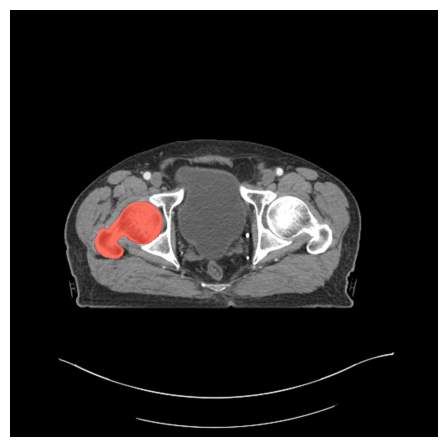

In [12]:
point_prompt_demo.show(img, gt)

In [13]:
preprocessed_img = preprocess_image(img)
preprocessed_gt = preprocess_gt(gt)

In [14]:
batch = {"image": preprocessed_img,
         "image_name": image_name,
         "gt2D_orig": preprocessed_gt}

medsam_lite_pred, coords = point_prompt_demo.infer(batch)

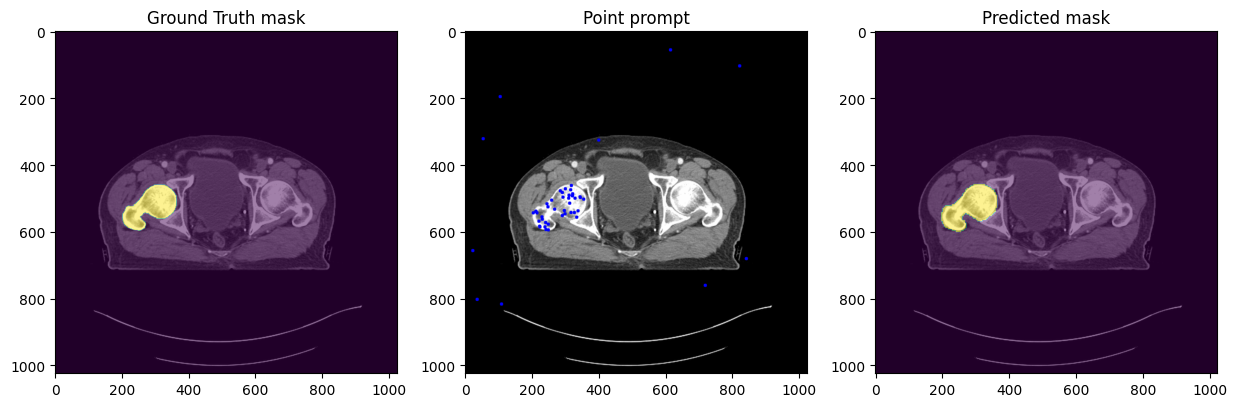

In [15]:
pred_binary = medsam_lite_pred[0] > 0.0
pred_mask = torchvision.transforms.functional.resize(
    pred_binary,
    (1024, 1024),
    interpolation=2
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
orig_img = batch["image"].squeeze().detach().permute(1, 2, 0)
gt2D_orig = batch["gt2D_orig"]

img_name = batch["image_name"]
img = np.load(os.path.join("data/WORD/test_CT_Abd/imgs", img_name), 'r', allow_pickle=True)
img = (img * 255).astype(np.uint8)

axs[0].imshow(orig_img, cmap='gray')
axs[0].imshow(gt2D_orig.squeeze().detach().cpu(), alpha=0.5, cmap='viridis')
axs[0].set_title("Ground Truth mask")

for x, y in coords.squeeze():
    cv2.circle(img, (int(x.item()), int(y.item())), 5, (0, 0, 255), -1)
axs[1].imshow(img)
axs[1].set_title("Point prompt")

axs[2].imshow(orig_img, cmap='gray')
axs[2].imshow(pred_mask.squeeze().detach().cpu(), alpha=0.5, cmap='viridis')
axs[2].set_title("Predicted mask")
plt.show()